# Miscellaneous testing plots

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import csv
import pickle
import os

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
import scipy
import math
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## FreeSolv molecular overview

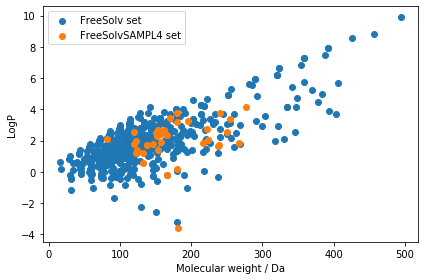

In [3]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors

# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', usecols=["SMILES", "experimental reference (original or paper this value was taken from)"])
freesolv_df.columns = ["SMILES", "EXP_TAG"]
# iterate and create a simple nested list with the smiles 
# and experimental tag (that shows whether the cpd is wymer set or not):
property_collection = []
for idx, row in freesolv_df.iterrows():
    # extract which set this compound belongs to:
    if row["EXP_TAG"] == "SAMPL4_Guthrie":
        nametag = "FreeSolvSAMPL4 set"
    else: 
        nametag = "FreeSolv set"
    # compute MW and logp from smiles:
    m = Chem.MolFromSmiles(row["SMILES"])

    mol_weight = rdMolDescriptors.CalcExactMolWt(m)
    logp = rdMolDescriptors.CalcCrippenDescriptors(m)[0]
    property_collection.append([nametag, mol_weight, logp])
    
# generate a df and plot:
labels = ["nametag", "Molecular weight / Da", "LogP"]
properties_df = pd.DataFrame.from_records(property_collection, columns=labels)
properties_df_freesolv = properties_df.loc[properties_df["nametag"] == "FreeSolv set"]
properties_df_wymer = properties_df.loc[properties_df["nametag"] == "FreeSolvSAMPL4 set"]

plt.scatter(properties_df_freesolv["Molecular weight / Da"], properties_df_freesolv["LogP"], label="FreeSolv set")
plt.scatter(properties_df_wymer["Molecular weight / Da"], properties_df_wymer["LogP"], label="FreeSolvSAMPL4 set")

plt.xlabel("Molecular weight / Da")
plt.ylabel("LogP")
plt.legend()
plt.tight_layout()
plt.savefig("OUTPUTS/freesolv_mw_logp_overview.png", dpi=300)
plt.show()

## Increasing training set size; effect on test accuracies

All four ML models; take feature set and hyperparameters of top performing models. Take the full training sets to train on, not cross-validated.

In [2]:
def trainModel(trainingset, hyperparameter_input, ml_model_type, PML=False):
    # train a ML model on a training set with provided hyperparameters; return the trained model.
    hyperparameters = hyperparameter_input

    # define train_X and train_y:
    if PML:
        train_y = trainingset["Experimental dGhydr (kcal/mol)"].values
    elif not PML:
        train_y = trainingset["dGoffset (kcal/mol)"].values
    train_X = trainingset.loc[:, trainingset.columns.str.startswith('PC')].values
        
    if ml_model_type ==  "SVM":
        model = SVR(kernel="rbf",
               gamma=float(hyperparameters[0]),
               C=float(hyperparameters[1]),
               epsilon=float(hyperparameters[2]),
               verbose=False)
        
    elif ml_model_type == "RF":
        # finish this when RF has finished running.
        model = RandomForestRegressor(
                n_estimators = hyperparameters[0], 
                max_depth = hyperparameters[1], 
                min_samples_split = hyperparameters[2],
                bootstrap = hyperparameters[3],
                verbose=False)
           
    elif ml_model_type == "MLR":
        model = SGDRegressor(loss=hyperparameters[0],
               n_iter_no_change=int(hyperparameters[1]),
               alpha=float(hyperparameters[2])
               )
   
    elif ml_model_type == "DNN":
          model = MLPRegressor(
                activation=hyperparameters[0],
                solver=hyperparameters[1],
                hidden_layer_sizes=hyperparameters[2],
                beta_1=float(hyperparameters[3]),
                beta_2=float(hyperparameters[4]),
                epsilon=float(hyperparameters[5]),
                max_iter=5000
                       )
    else:
        print("Unrecognised ML model", ml_model_type)
            
    # now train the model:
    model.fit(train_X, train_y)
    
    return model

In [3]:
def correctWymerComputeSTATS(dGoffset_predictions, test_calc, test_exp):
    # correct Wymer FEP predictions in SAMPL4.
    wymer_predictions = test_calc
    corrected_wymer_predictions = []
    
    # now correct each wymer prediction:
    for offset_pred, wymer_pred in zip(dGoffset_predictions, wymer_predictions):
        
        corrected = wymer_pred + offset_pred
        corrected_wymer_predictions.append(corrected)
    
    mue = mean_absolute_error(corrected_wymer_predictions, test_exp)
    rmse = math.sqrt(mean_squared_error(corrected_wymer_predictions, test_exp))
    tau = scipy.stats.kendalltau(corrected_wymer_predictions, test_exp)[0]
    r = scipy.stats.pearsonr(corrected_wymer_predictions, test_exp)[0]
    return [mue, rmse, tau, r]

In [4]:
def compute_stats_range(x_vals, y_vals, x_stds):
    ### computes statistic intervals given x, y and x uncertainties.
    r, p_ignore = scipy.stats.pearsonr(x_vals, y_vals)
    mue = mean_absolute_error(x_vals, y_vals)
    rmse = mean_squared_error(x_vals, y_vals)
    rho, p_ignore = scipy.stats.spearmanr(x_vals, y_vals)
    tau, p_ignore = scipy.stats.kendalltau(x_vals, y_vals)
    
 
    # compute the higher bound for x using the standard deviation:
    upper_x_vals = []
    for x, y, std in zip(x_vals, y_vals, x_stds):
        if x <= y:
            upper_x = x-std
        elif x > y:
            upper_x = x + std
        upper_x_vals.append(upper_x)

    # with this new array, compute stats side by side and subtract to get the uncertainty:
    upper_r, p_ignore = scipy.stats.pearsonr(upper_x_vals, y_vals)
    r_range = r - upper_r      

    upper_mue = mean_absolute_error(upper_x_vals, y_vals)
    mue_range = upper_mue - mue

    upper_rmse = mean_squared_error(upper_x_vals, y_vals)
    rmse_range = upper_rmse - rmse

    upper_rho, p_ignore = scipy.stats.spearmanr(upper_x_vals, y_vals)
    rho_range = rho - upper_rho

    upper_tau, p_ignore = scipy.stats.kendalltau(upper_x_vals, y_vals)
    tau_range = tau - upper_tau

    results = [ r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range ]
   
    return results

In [5]:
# # Find the top performing features per ML model:
# ML_models = ["SVM", "RF", "MLR", "DNN"]

# Only run SVM computations:
ML_models = ["SVM"]
sampl4_stats_df = pd.read_csv("OUTPUTS/SAMPL4_predictions_statistics.csv")
top_features = [["MolPropsAPFP", "MolProps"]]

In [6]:
# Find the ten different hyperparameter configurations (we ran ten replicates in hyperparameter optimisation):
ml_hyperparameter_collection = [['SVM',
  [['0.001', '10.0', '0.01'], # these are the configurations the hybrid models converged to
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01'],
  ['0.001', '10.0', '0.01']],
  [['0.001', '100.0', '0.001'], # these are the configurations the PML models converged to
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001'],
  ['0.001', '100.0', '0.001']]]]


In [7]:
# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)').sort_index()

# extract experimental and calculated hydration free energies for just the Wymer et al subset:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','experimental value (kcal/mol)']
test_wymer = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','Mobley group calculated value (GAFF) (kcal/mol)'].sort_index()


ml_hyperparameter_collection now is a nested list of the shape [[MLmodel, [hyperparameters1], [hyperparameters..], hyperparameters10]]..]

In [8]:
def computeSAMPL4Rank(stat_value, stat_type):
    # for a given statistical outcome, compute the rank in the SAMPL4 challenge retrospectively
    inserted_rank = None
    # load SAMPL4 data:
    sampl4_df = pd.read_csv('./datasets/backend/table_3.csv', dtype={'ID':str})
    sampl4_df = sampl4_df.set_index("ID")

    if stat_type == "MUE":
        sampl4_outcomes = np.sort(np.append(sampl4_df["AUE"].values, stat_value)).tolist()
        inserted_rank = sampl4_outcomes.index(stat_value) + 1 # arrays start at 0 but competitions don't
    elif stat_type == "RMSE":
        sampl4_outcomes = np.sort(np.append(sampl4_df["RMS"].values, stat_value)).tolist()
        inserted_rank = sampl4_outcomes.index(stat_value) + 1 # arrays start at 0 but competitions don't
    elif stat_type == "TAU":
        sampl4_outcomes = np.sort(np.append(sampl4_df["tau"].values, stat_value)).tolist()[::-1]
        inserted_rank = sampl4_outcomes.index(stat_value) + 1 # arrays start at 0 but competitions don't
    elif stat_type == "R":
        sampl4_outcomes = np.sort(np.append(sampl4_df["R"].values, stat_value)).tolist()[::-1]
        inserted_rank = sampl4_outcomes.index(stat_value) + 1 # arrays start at 0 but competitions don't
    if not inserted_rank:
        print("Unable to compute the rank for this hybrid entry, maybe your statistics type is wrong?", stat_type)
    return inserted_rank
        
        
    

In [9]:
# Per ML model/ featureset combination, load the corresponding training+test set:
with open("OUTPUTS/grow_trainingset_outputs.csv", "w") as writefile:
    writer = csv.writer(writefile)
    
    for ml_model, featureset in zip(ml_hyperparameter_collection, top_features):
        model_name = ml_model[0]
        featureset_hyb = featureset[0]
        featureset_pml = featureset[1]
        print("Running", model_name)

        training_set_hyb = pd.read_csv("./datasets/DATASETS/train_"+featureset_hyb+".csv")
        test_set_hyb = pd.read_csv("./datasets/DATASETS/test_"+featureset_hyb+".csv")
        test_X_hyb = test_set_hyb.loc[:, test_set_hyb.columns.str.startswith('PC')].values
        test_y_hyb = test_set_hyb["dGoffset (kcal/mol)"].values
        
        training_set_pml = pd.read_csv("./datasets/DATASETS/null_train_"+featureset_pml+".csv")
        test_set_pml = pd.read_csv("./datasets/DATASETS/null_test_"+featureset_pml+".csv")
        test_X_pml = test_set_pml.loc[:, test_set_pml.columns.str.startswith('PC')].values
        test_y_pml = test_set_pml["Experimental dGhydr (kcal/mol)"].values        

        mue_ranks_allreps = []
        rmse_ranks_allreps = []
        tau_ranks_allreps = []
        r_ranks_allreps = [] 
        # for each replicate (i.e. hyperparameter configuration), run training on random subsamples of the trainingset:
        for replicate in np.linspace(0,9,10, dtype=int):
            print("Running replicate:", replicate)
            mue_ranks = []
            rmse_ranks = []
            tau_ranks = []
            r_ranks = [] 

            model_results = []
            pml_model_results = []
            
            # we want to make random subselections of this trainingset with increments to decrease expense:
            # with increment = 3, running all models will take ~4h of which the vast majority of computing time 
            # is occupied by DNN and RF.
            bin_sizes = np.linspace(1, len(training_set_hyb), int(len(training_set_hyb)/3), dtype=int)

            # now for each trainingset subset (of binsize), train the corresponding ML model:
            for trainingset_bin in bin_sizes:
                # take a random chunk of binsize of the trianingset:
                trainingset_sample_hyb = training_set_hyb.sample(trainingset_bin)
                trainingset_sample_pml = training_set_pml.sample(trainingset_bin)
                
                
                hyperparameters_hyb = ml_model[1][replicate]
                hyperparameters_pml = ml_model[2][replicate]

                # now train the model:
                trained_model =  trainModel(trainingset_sample_hyb, hyperparameters_hyb, model_name)
                trained_model_pml =  trainModel(trainingset_sample_pml, hyperparameters_pml, model_name, PML=True)

                # now predict on SAMPL4:
                predictions = trained_model.predict(test_X_hyb)
                predictions_pml = trained_model_pml.predict(test_X_pml)
                # and compute the error on experimental measures with the corrected model:
                hybrid_stats = correctWymerComputeSTATS(predictions, test_wymer, test_exp)
                hybrid_error = hybrid_stats[0]
                model_results.append(hybrid_error)
                
                # and the PML model:
                pml_error = mean_absolute_error(predictions_pml, test_exp)
                pml_model_results.append(pml_error)
                # now compute the ranking of these stats in the SAMPL4 challenge for just SVM:
                if model_name == "SVM":
                    mue_rank = computeSAMPL4Rank(hybrid_stats[0], stat_type="MUE")
                    mue_ranks.append(mue_rank)
                    rmse_rank = computeSAMPL4Rank(hybrid_stats[1], stat_type="RMSE")
                    rmse_ranks.append(rmse_rank)
                    tau_rank = computeSAMPL4Rank(hybrid_stats[2], stat_type="TAU")
                    tau_ranks.append(tau_rank)
                    r_rank = computeSAMPL4Rank(hybrid_stats[3], stat_type="R")
                    r_ranks.append(r_rank)
            if model_name == "SVM":
                mue_ranks_allreps.append(mue_ranks)
                rmse_ranks_allreps.append(rmse_ranks)
                tau_ranks_allreps.append(tau_ranks)
                r_ranks_allreps.append(r_ranks)
                               
                                                                                         
            # write out these values:
            data_line = [model_name, "hybrid", featureset_hyb, replicate]
            for result_value in model_results:
                data_line.append(result_value)
            writer.writerow(data_line)
            
            data_line = [model_name, "pml", featureset_pml, replicate]
            for result_value in pml_model_results:
                data_line.append(result_value)
            writer.writerow(data_line)

        if model_name == "SVM":
            mue_rank_mean = np.mean(mue_ranks_allreps, axis=0)
            mue_rank_unc = np.std(mue_ranks_allreps, axis=0)
            rmse_rank_mean = np.mean(rmse_ranks_allreps, axis=0)
            rmse_rank_unc = np.std(rmse_ranks_allreps, axis=0)
            tau_rank_mean = np.mean(tau_ranks_allreps, axis=0)
            tau_rank_unc = np.std(tau_ranks_allreps, axis=0)
            r_rank_mean = np.mean(r_ranks_allreps, axis=0)
            r_rank_unc = np.std(r_ranks_allreps, axis=0)


Running SVM
Running replicate: 0
Running replicate: 1
Running replicate: 2
Running replicate: 3
Running replicate: 4
Running replicate: 5
Running replicate: 6
Running replicate: 7
Running replicate: 8
Running replicate: 9


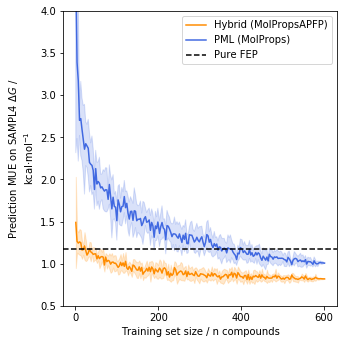

In [10]:
fep_mue = 1.173 # Wymer et al MUE

# derive x axis from sample training set:
training_set = pd.read_csv("./datasets/DATASETS/train_APFP.csv")
x_axis_values = np.linspace(1, len(training_set), int(len(training_set)/3), dtype=int)

hybrid_errors = []
pml_errors = []


with open("OUTPUTS/grow_trainingset_outputs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        if row[1] == "hybrid":
            hybrid_errors.append(row[4:])
            hybrid_featureset = row[2]
        elif row[1] == "pml":
            pml_errors.append(row[4:])
            pml_featureset = row[2]

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=[5, 5])

# we want to plot averages because the model errors are quite noisy:
hybrid_errors_floats = []
for replicate_errors in hybrid_errors:
    # float the MUE values:
    replicate_errors = [ float(error) for error in replicate_errors ]
    hybrid_errors_floats.append(replicate_errors)

hybrid_mean_errors = np.mean(hybrid_errors_floats, axis=0)
hybrid_std_errors = np.std(hybrid_errors_floats, axis=0)

pml_errors_floats = []
for replicate_errors in pml_errors:
    # float the MUE values:
    replicate_errors = [ float(error) for error in replicate_errors ]
    pml_errors_floats.append(replicate_errors)
pml_mean_errors = np.mean(pml_errors_floats, axis=0)
pml_std_errors = np.std(pml_errors_floats, axis=0)

###### HYBRID
# standard devation bounds for confidence regions:
y1 = [i - sd for i, sd in zip(hybrid_mean_errors, hybrid_std_errors)]
y2 = [i + sd for i, sd in zip(hybrid_mean_errors, hybrid_std_errors)]

ax.fill_between(x_axis_values, y1, y2,
        alpha=0.2, color="darkorange"
       )
ax.plot(x_axis_values, hybrid_mean_errors, color="darkorange", label="Hybrid "+"("+featureset[0]+")")

####### PML
y1 = [i - sd for i, sd in zip(pml_mean_errors, pml_std_errors)]
y2 = [i + sd for i, sd in zip(pml_mean_errors, pml_std_errors)]

ax.fill_between(x_axis_values, y1, y2,
        alpha=0.2, color="royalblue"
       )
ax.plot(x_axis_values, pml_mean_errors, color="royalblue", label="PML "+"("+featureset[1]+")")


ax.axhline(fep_mue, ls="--", c="black", label="Pure FEP")
ax.set_ylim(0.5, 4)


ax.legend(loc="upper right") 



ax.set_xlabel("Training set size / n compounds")

ax.set_ylabel("Prediction MUE on SAMPL4 $\Delta G$ / \nkcal$\cdot$mol$^{-1}$")

plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig("OUTPUTS/grow_trainset_expt.png", dpi=300)
plt.show()

Now let's see what growing the training set does to the actual ranking of the statistics. Pick just SVM to save time.

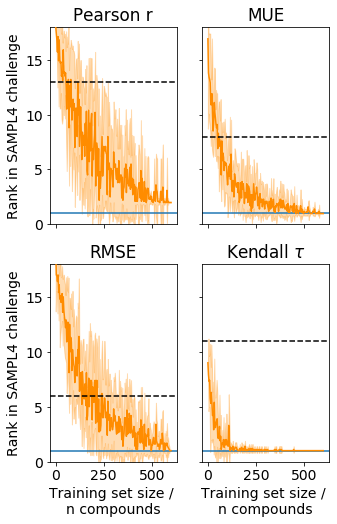

In [11]:
x_values = np.linspace(1, 600, len(mue_rank_mean))

fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(5, 8))

axes[0][0].fill_between(x_values, r_rank_mean-r_rank_unc, r_rank_mean+r_rank_unc, alpha=0.3, color="darkorange")
axes[0][0].plot(x_values, r_rank_mean, zorder=100, color="darkorange")
axes[0][0].set_title("Pearson r")
axes[0][0].axhline(13, ls="--", color="black", zorder=200)

axes[0][1].fill_between(x_values, mue_rank_mean-mue_rank_unc, mue_rank_mean+mue_rank_unc, alpha=0.3, color="darkorange")
axes[0][1].plot(x_values, mue_rank_mean, zorder=100, color="darkorange")
axes[0][1].axhline(8, ls="--", color="black", zorder=200)
axes[0][1].set_title("MUE")

axes[1][0].fill_between(x_values, rmse_rank_mean-rmse_rank_unc, rmse_rank_mean+rmse_rank_unc, alpha=0.3, color="darkorange")
axes[1][0].plot(x_values, rmse_rank_mean, zorder=100, color="darkorange")
axes[1][0].set_title("RMSE")
axes[1][0].axhline(6, ls="--", color="black", zorder=200)

axes[1][1].fill_between(x_values, tau_rank_mean-tau_rank_unc, tau_rank_mean+tau_rank_unc, alpha=0.3, color="darkorange")
axes[1][1].plot(x_values, tau_rank_mean, zorder=100, color="darkorange")
axes[1][1].set_title(r"Kendall $\tau$")
axes[1][1].axhline(11, ls="--", color="black", zorder=200)

for ax in axes.flat:
    ax.set_ylim(0,18)
    ax.axhline(1)

axes[0][0].set_ylabel("Rank in SAMPL4 challenge")
axes[1][0].set_ylabel("Rank in SAMPL4 challenge")
        
axes[1][0].set_xlabel("Training set size / \nn compounds")
axes[1][1].set_xlabel("Training set size / \nn compounds")

plt.rcParams.update({'font.size': 14})
plt.savefig("OUTPUTS/grow_trainset_expt_ranking.png", dpi=300)
plt.show()

## Average error made in predicting dGoffset 

Barplot of all Wymer ligands on X-axis, for each ligand, plot all four models with STD. 

In [12]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors
def computeMolProps(mol_entry_names):
    # for a given array of freesolv molecule names, compute some molecular properties.
    properties_dict = {
        "NumHydroxyls" : [],
        "MolWeight" : [],
        "LogP" : [],
        "NumRings" : [],
        "NumRotBonds" : [],
        "TPSA" : []
                        }
    
    for mol_name in mol_entry_names:
        path_to_mol = "./datasets/backend/freesolv/"+mol_name+".sdf"
        m = Chem.MolFromMolFile(path_to_mol)
        
        # number of alcohols:
        alcohol = Chem.MolFromSmarts('CO')
        num_alcohols = len(m.GetSubstructMatches(alcohol))
        properties_dict["NumHydroxyls"].append(num_alcohols)
        
        # mol weight:
        mol_weight = rdMolDescriptors.CalcExactMolWt(m)
        properties_dict["MolWeight"].append(mol_weight)
        
        # LogP:
        logp = rdMolDescriptors.CalcCrippenDescriptors(m)[0]
        properties_dict["LogP"].append(logp)
        
        # num rings:
        num_rings = rdMolDescriptors.CalcNumRings(m)
        properties_dict["NumRings"].append(num_rings)
        
        # num rotatable bonds:
        num_rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(m)
        properties_dict["NumRotBonds"].append(num_rot_bonds)
        
        # TPSA:
        tpsa = Descriptors.TPSA(m)
        properties_dict["TPSA"].append(tpsa)
        
    return properties_dict

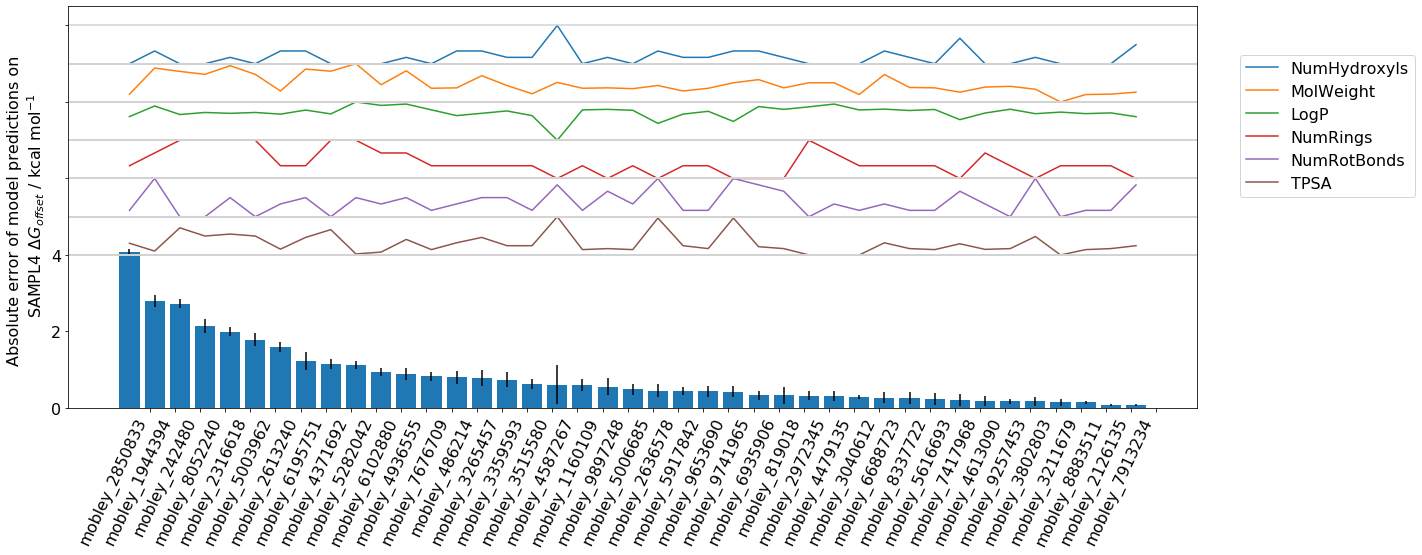

In [53]:
plotting_df = pd.DataFrame()
ML_models = ["SVM", "RF", "MLR", "DNN"]

for ml_model, featureset in zip(ML_models, top_features):
    featureset=  featureset[0]
    test_X = pd.read_csv("./datasets/DATASETS/test_"+featureset+'.csv', index_col='ID').iloc[:,:-2].sort_index()
    test_y = pd.read_csv("./datasets/DATASETS/test_"+featureset+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()["dGoffset (kcal/mol)"].values
    
    
    # now load all models (5 folds x 10 replicates = 50 models), exclude null models:
    model_paths = glob.glob(ml_model+"/output/"+featureset+"/fold*.pickle")
    model_paths = [ model_path for model_path in model_paths if not "null" in model_path ]
    
    # for each model, predict on testset; compute error per datapoint (i.e. compound):
    model_errors_per_compound = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        
        # should this be absolute?
        error_per_compound = abs(test_y - predicted)
        model_errors_per_compound.append(error_per_compound)
    mean_error_per_compound = np.mean(model_errors_per_compound, axis=0)
    std_error_per_compound = np.std(model_errors_per_compound, axis=0)
    
    errors_per_cpd_df = pd.DataFrame.from_dict({
        "Compound" : test_X.index,
        "Error mean" : mean_error_per_compound,
        "STD mean" : std_error_per_compound,
        "ML model" : ml_model
    })
    plotting_df = plotting_df.append(errors_per_cpd_df)
# compute average error per compound (for sorting x axis):
new_index = plotting_df.groupby(by="Compound").mean().sort_values(by="Error mean", ascending=False).index
plotting_df_sorted = plotting_df.set_index("Compound").loc[new_index.values]


fig = plt.figure(figsize=(20,8))
# set width of bars
bar_width = 0.8
 
# set height of bar
bars1 = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "SVM"]["Error mean"].values
# bars2 = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "RF"]["Error mean"].values
# bars3 = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "MLR"]["Error mean"].values
# bars4 = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "DNN"]["Error mean"].values

bars1_err = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "SVM"]["STD mean"].values
# bars2_err = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "RF"]["STD mean"].values
# bars3_err = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "MLR"]["STD mean"].values
# bars4_err = plotting_df_sorted.loc[plotting_df_sorted["ML model"] == "DNN"]["STD mean"].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
# r2 = [x + bar_width for x in r1]
# r3 = [x + bar_width for x in r2]
# r4 = [x + bar_width for x in r3]
 
# Make the plot
plt.bar(r1, bars1, yerr=bars1_err, width=bar_width)
# plt.bar(r2, bars2, yerr=bars2_err, width=bar_width, label='RF')
# plt.bar(r3, bars3, yerr=bars3_err, width=bar_width, label='MLR')
# plt.bar(r4, bars4, yerr=bars4_err, width=bar_width, label='DNN')

# now plot molecular properties as lines:
bump = 0
for property_name, values in computeMolProps(new_index.values).items():
    
    # we need to normalise properties for clearer plotting; if needed properties can be retraced:
    amin, amax = min(values), max(values)
    for i, val in enumerate(values):
        values[i] = ((val-amin) / (amax-amin)) + 9 - bump
    plt.plot(new_index, values, label=property_name)
    # separate the lines:
    bump += 1

# formatting:
plt.xticks([r + bar_width for r in range(len(bars1))], new_index.values, rotation=65, ha="right")
plt.ylabel("Absolute error of model predictions on \n SAMPL4 $\Delta G_{offset}$ / kcal mol$^{-1}$")
for i in np.linspace(4, 10, dtype=int):
    plt.axhline(i, color="lightgrey")
new_ylabels = [0, 2, 4, "", "", ""]
plt.yticks(ticks=[0, 2, 4, 6, 8, 10], labels=[0, 2, 4, "", "", ""])

plt.legend(bbox_to_anchor=(0.7, 0.4,0.5,0.5))
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

plt.savefig("OUTPUTS/svm_model_errors_per_cmpd.png", dpi=300)
plt.show()



## Convergence plots of ECFP2-8 for SVM

Retrain SVM, same protocol, but now with features only consisting of ECFP with different steps in radius. 

In [14]:
# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args

import statistics

# Global variables:
model_type = 'SVM'
kernel = 'rbf'
label_col = 'dGoffset (kcal/mol)'
null_label_col = 'Experimental dGhydr (kcal/mol)'

# Set data processing configurations:
n_calls = 50  # Number of Bayesian optimisation loops for hyper-parameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# Path variables:
datasets_dr = './datasets/DATASETS/'
SDF_dr = './datasets/backend/freesolv/'
freesolv_loc = './datasets/backend/freesolv_database.txt'

In [16]:
feature_sets = ["ECFP2","ECFP4", "ECFP6", "ECFP8"]
training_sets = []
for feature_set in feature_sets:
    
    # load in this feature set:
    train_path = datasets_dr + 'train_'+feature_set+'.csv'
    train_df = pd.read_csv(train_path, index_col='ID').iloc[:,:-1]
    # assign a name attribute to recover feature type (called by df.name)
    train_df.name = feature_set
    training_sets.append(train_df)

In [17]:
def split_dataset(dataset, n_splits, random_state, label_name, feature_type):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []
    global offset_col_name

    for train, validate in kf.split(dataset):
        training = dataset.iloc[train]
        train_labels = training[label_name]
        train_set = training.drop(label_name, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[label_name]
        validate_set = validating.drop(label_name, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )


    return kfolds

In [18]:
# Call function
CV_training_sets = []
for train_df in training_sets:
    kfolds = [train_df.name, split_dataset(
                        train_df, 
                        n_splits, 
                        random_state, 
                        label_col, 
                        feature_type=train_df.name
                            )]
    CV_training_sets.append(kfolds)

In [19]:
# Set hyper-parameter ranges and append to list.
dim_param_C = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_C")
dim_param_gamma = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_gamma")
dim_param_epsilon = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_epsilon")

# gp_minimize dimensions
dimensions = [dim_param_C, dim_param_gamma, dim_param_epsilon]

In [20]:
def create_model(param_gamma, param_C, param_epsilon):
    """Returns a SVR class instance."""
    
    return SVR(kernel=kernel,
               gamma=param_gamma,
               C=param_C,
               epsilon=param_epsilon,
               verbose=False)

In [21]:
def train_model(fold, fold_num, feature_type, writer, replicate_tag, *args):
    """
    1. Unpack data.
    2. Define fitness function for guassian process optmisation.
    3. Decorate fitness with pre-defined hyper-parameter ranges.
    4. Return and pickle final gp_minimize object.
    """
    

    # Retrieve data sets and convert to numpy array
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # Specify whether model is null.
    null = ''
    for arg in args:
        null = arg + '_'
    
    # Define function for gaussian process optimisation
    @use_named_args(dimensions=dimensions)
    def fitness(param_C, param_gamma, param_epsilon):
        """Function for gaussian process optmisation."""

        # Create SVR model
        model = create_model(param_C, param_gamma, param_epsilon)

        # Train model on training data
        model.fit(train_X, train_y)

        # Validate model
        predicted_y = model.predict(validate_X)
        mae = mean_absolute_error(validate_y, predicted_y)

        # Update statistics
        writer.writerow([fold_num, mae, [param_C, param_gamma, param_epsilon]])

        # Check if model improves
        global best_mae
        if mae < best_mae:
            # Update new model accuracy.
            best_mae = mae
                    
        return mae
    
    # Starting parameters
    default_parameters = [1.0, 1.0, 1.0]
    # Optimise hyper-parameters
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters,
                                verbose=False,
                                #callback=[tqdm_skopt(total=n_calls, desc='Fold {}'.format(fold_num))]
                               )

    # Save skopt object; finish up:

    
    return search_result

In [22]:
# Run 10 replicates:
for replicate in range(1,11):
    replicate_tag = "repl"+str(replicate)

    # Call train_model and save gp_minimize results.
    for kfolds in CV_training_sets:
        name = kfolds[0]
        kfolds = kfolds[1]
        print("Training on:", name, replicate_tag)
#         testset = pd.read_csv("./datasets/DATASETS/test_"+name+".csv", index_col='ID').iloc[:,:-1]
#         test_y = testset["dGoffset (kcal/mol)"].values
#         test_X = testset.drop("dGoffset (kcal/mol)", axis=1).values


        # Init. training statistics logger.
        if not os.path.exists('OUTPUTS/ECFP_TESTS/'+name):
            os.mkdir('OUTPUTS/ECFP_TESTS/'+name)
        with open('OUTPUTS/ECFP_TESTS/'+name+'/mae_per_call'+replicate_tag+'.csv', 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['Fold', 'MAE (kcal/mol)', 'Hyperparameters'])

            for fold_num, fold in enumerate(kfolds):
                best_mae = np.inf
                gp_results = train_model(fold, 
                                          fold_num + 1, 
                                          feature_type=name, 
                                          writer=writer,
                                          replicate_tag=replicate_tag,
                                        )
    


Training on: ECFP2 repl1
Training on: ECFP4 repl1
Training on: ECFP6 repl1
Training on: ECFP8 repl1
Training on: ECFP2 repl2
Training on: ECFP4 repl2
Training on: ECFP6 repl2
Training on: ECFP8 repl2
Training on: ECFP2 repl3
Training on: ECFP4 repl3
Training on: ECFP6 repl3
Training on: ECFP8 repl3
Training on: ECFP2 repl4
Training on: ECFP4 repl4
Training on: ECFP6 repl4
Training on: ECFP8 repl4
Training on: ECFP2 repl5
Training on: ECFP4 repl5
Training on: ECFP6 repl5
Training on: ECFP8 repl5
Training on: ECFP2 repl6
Training on: ECFP4 repl6
Training on: ECFP6 repl6
Training on: ECFP8 repl6
Training on: ECFP2 repl7
Training on: ECFP4 repl7
Training on: ECFP6 repl7
Training on: ECFP8 repl7
Training on: ECFP2 repl8
Training on: ECFP4 repl8
Training on: ECFP6 repl8
Training on: ECFP8 repl8
Training on: ECFP2 repl9
Training on: ECFP4 repl9
Training on: ECFP6 repl9
Training on: ECFP8 repl9
Training on: ECFP2 repl10
Training on: ECFP4 repl10
Training on: ECFP6 repl10
Training on: ECFP8 rep

In [44]:
def mae_convergence(MAE_output_dfs):
    plt.rcParams['image.cmap'] = 'gray'
    plt.figure(figsize=(6,6))
    # x values
    x = np.linspace(1, n_calls, n_calls)

    for MAE_outputs in MAE_output_dfs:
        MAEs_all_reps = []
        for MAE_output in MAE_outputs:

            result_maes = MAE_output[2]
            name = MAE_output[1]
            # y values
            mae = [result_maes.loc[result_maes.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
                   for fold in range(1, n_splits + 1)]
            cumm_mae = list(zip(*mae))
            mean_MAEs_this_rep = [statistics.mean(call) for call in cumm_mae]
            MAEs_all_reps.append(mean_MAEs_this_rep)
        
        y = np.mean(MAEs_all_reps, axis=0)
        std = np.std(MAEs_all_reps, axis=0)
        

        # standard devation bounds
        y1 = [i - sd for i, sd in zip(y, std)]
        y2 = [i + sd for i, sd in zip(y, std)]
        
        plt.plot(x, y,
                linewidth=2, label=name
                #label='Average MAE over {} folds'.format(n_splits)
               )
        # plot standard deviation fill bounds
        plt.fill_between(x, y1, y2,
                        alpha=0.2,
                        #label='Standard deviation'
                       )
        
    plt.axhline(0.52, ls="--", c="black", label="Top-performer")
    plt.legend()
    plt.ylim(0.5, 1.1)
    plt.xlim(1,50)
    plt.xlabel('Hyperparameter optimisation progression / n calls')
    plt.ylabel('Training validation \n mean absolute error / kcal mol$^{-1}$')
    plt.tight_layout()
    plt.savefig('OUTPUTS/ECFP_TESTS/convergence_plot_ecfps.png', dpi=300)
    plt.show()
    
    

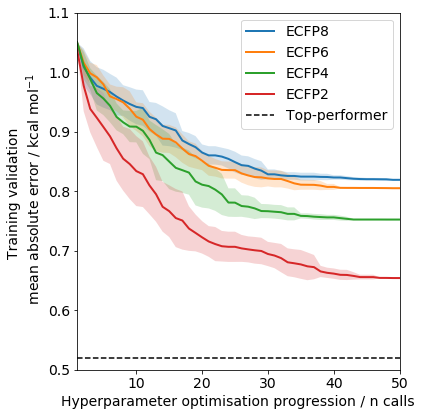

In [45]:
# make a list with all our MAE outputs:
MAE_output_dfs = []
replicate_tags = [ "repl"+str(value) for value in np.arange(1,11) ]
maes_per_featureset = []
for feature_set in list(reversed(feature_sets)):
    maes_all_replicates = []
    for replicate in replicate_tags:
        mae_logger = 'OUTPUTS/ECFP_TESTS/'+feature_set + '/mae_per_call'+replicate+'.csv'
        mae_df = pd.read_csv(mae_logger, usecols=[0,1]).head(n_calls*n_splits)  # Load previously defined training statistics logger.
        maes_all_replicates.append([replicate, feature_set, mae_df])
    maes_per_featureset.append(maes_all_replicates)
        

# Plot convergence plots.

mae_convergence(maes_per_featureset)  

## Test on SAMPL5 challenge

In [ ]:
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import rdmolfiles, rdMolDescriptors, AllChem

In [ ]:
def kCaltokJ(query_value):
    # convert an input value from kCal to kJ.
    if type(query_value) == float or type(query_value) == int:
        query_value_in_kJ = query_value / 0.23890295761862
    else:
        print("Supplied input value is nan", query_value)
        
    return query_value_in_kJ

In [ ]:
# import the SAMPL5 experimental data; exclude compounds without logD values:
sampl5_fulldf = pd.read_csv("./datasets/backend/SAMPL5/sampl5_exp.csv")
sampl5_logDdf = sampl5_fulldf[sampl5_fulldf["log D chx/wat"].notna()]
sampl5_logDdf = sampl5_logDdf[["MoleculeID", "SMILES", "log D chx/wat", "uncertainty"]]

sampl5_exp_data = sampl5_logDdf.set_index("MoleculeID")
print(len(sampl5_logDdf))

In [ ]:
# read in the Mobley computed energies, both in water and chx:
mobley_fulldf = pd.read_csv("./datasets/backend/SAMPL5/SAMPL5_withFreeEnergy.txt")
mobley_fulldf = mobley_fulldf.set_index("SAMPL ID")

combined_df = pd.concat([mobley_fulldf, sampl5_exp_data], axis=1,sort=False)
combined_df.head(8)
# we will be correcting dF wat(kJ/mol); then appending dFwat,corr to this DF.

In [ ]:
# generate rdkit mol objects per molecule (SMILES entries):
sampl5_logD_nlist = sampl5_logDdf[["MoleculeID", "SMILES"]].values.tolist()
mol_nlist = []

for sampl5_entry in sampl5_logD_nlist:
    m = Chem.MolFromSmiles(sampl5_entry[1])
    mol_nlist.append([sampl5_entry[0], m])

In [ ]:
def genTestSet(mol_nlist, fp_type):
    # computes features for a set of molecules
    
    names = [entry[0] for entry in mol_nlist]
    molecules = [entry[1] for entry in mol_nlist]
    
    # calculate Mordred descriptors:
    mordred_df = None
    if "MolProps" in fp_type:
        calc = Calculator(descriptors, ignore_3D=False)
        mordred_df = calc.pandas(molecules, quiet=True)
        mordred_df.index = names
        
    # Calculate fingerprint:
    fp = None
    fp_collection = []
    for mol in molecules:
        mol.UpdatePropertyCache(strict=False)
        if "APFP" in fp_type:
            fp = np.array(list(rdMolDescriptors.GetHashedAtomPairFingerprint(mol, 256)))
        elif "ECFP6" in fp_type:
            fp = np.array(list(AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=1024)))
        elif "TOPOL" in fp_type:
            fp = np.array(list(Chem.RDKFingerprint(mol)))  
        elif fp_type == "X-NOISE":
            fp = np.array(list(np.random.randint(0,100,200)))
        fp_collection.append(fp)
    fp_df = pd.DataFrame(fp_collection)
    fp_df.index = names
    fp_df.columns = ["pfp"+str(colname) for colname in fp_df.columns.values]
    
    # append the two feature types if needed:
    if fp is not None and mordred_df is not None:
        result_df = pd.concat([mordred_df, fp_df], axis=1)
    # or just return the feature as is:
    elif fp is not None:
        result_df = fp_df
    elif mordred_df is not None:
        result_df = mordred_df
    else:
        print("Failed to compute features for", fp_type)
    
        
        
    return result_df

In [ ]:
def prepTestSet(dataset, fp_type):
    # Normalises and reduced dimensionality (PCA) for a given collection of features (pandas DF).
    # We need to normalise and PCA with respect to the training set, these files have been saved earlier.
    
    #### Normalise #####
    # Load stats:
    stats = pd.read_csv("./datasets/backend/features_X/stats_"+fp_type+".csv", index_col=[0])
    # for molprops, the FreeSolv trainingset already has null columns removed. Remove these from the current dataset: 
    dataset = dataset[stats.index.values]

    def norm(x):
        return (x - stats["mean"]) / stats["std"]
    normed_data = norm(dataset).fillna(0).replace([np.inf, -np.inf], 0.0)

    #### Dimensionality reduction #####
    # load the correct PCA pickle:
    pca = pickle.load(open("./datasets/backend/features_X/pca_"+fp_type+".pkl",'rb'))

    # Transform the normalised test set:
    pca_data = pd.DataFrame(pca.transform(normed_data))

    # Reset column names to PCX.
    pca_col = np.arange(1, len(pca_data.columns) + 1).tolist()
    pca_col = ['PC' + str(item) for item in pca_col]
    pca_data.columns = pca_col
    pca_data.index = dataset.index
    
    # after PCA, the noise dataset can sometimes be one/two columns short compared to training 
    # (need same number of features for testing); circumvent by repeating the last column:
    if fp_type == "X-NOISE":
        correct_num_cols = len(pd.read_csv("./datasets/DATASETS/train_X-NOISE.csv").columns.values) - 3 #labels
        if not len(pca_data.columns) == correct_num_cols:
            num_cols_needed = correct_num_cols - len(pca_data.columns)
            # duplicate last column and append
            new_col_values = pca_data.iloc[:,-1].values
            for i in range(num_cols_needed):
                pca_data["PC_app"+str(i+1)] = new_col_values
                

    return pca_data
    

In [ ]:
# generate fingerprints for all the molecules:

feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

testset_collection = []
for fp_type in feature_sets:
    # import dataset with the proper features:
    dataset = genTestSet(mol_nlist, fp_type)
    # normalise and reduce wrt training set parameters:
    prepped_dataset = prepTestSet(dataset, fp_type)
    
    testset_collection.append([fp_type, prepped_dataset])

In [ ]:
def modelPredictor(model_paths, test_X):
    # given a list of model paths, pickle load them, predict on test_X and return mean and std of predictions.
    
    predictions = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        
        ##### Convert to kJ/mol from kCal/mol #####
        predicted = [ kCaltokJ(float(val)) for val in predicted ]
        
        predictions.append(predicted)

    predictions_mean = np.mean(predictions, axis=0)
    
    predictions_std = np.std(predictions, axis=0)

    return predictions_mean, predictions_std

#### Make predictions:

In [ ]:
ML_models = ["SVM", "RF", "MLR", "DNN"]
test_y = []

# ML_models = ["SVM", "MLR"]
predictions_collection = []
for ml_model in ML_models:
    ml_model_predictions = [[ml_model]]
    for testset in testset_collection:
        feature_type = testset[0]
        dataset = testset[1]
        test_X = dataset.values
        
        # load and predict with models:
        list_of_trained_models = glob.glob(ml_model+"/output/"+feature_type+"/*.pickle")
        
        corrector_models = [ model_path for model_path in list_of_trained_models if not "null" in model_path ]
        predicted_corrections = modelPredictor(corrector_models, test_X)
                
        null_models = [ model_path for model_path in list_of_trained_models if "null" in model_path ]
        predicted_dF_null = modelPredictor(null_models, test_X)
        
        ml_model_predictions.append([feature_type, predicted_corrections, predicted_dF_null])
    predictions_collection.append(ml_model_predictions)

#### Process predictions & plot:

In [ ]:
# First, plot original SAMPL5 FEP entry:
exp_logD = combined_df["log D chx/wat"]
fep_logD = combined_df["logD"].values

plt.figure(figsize=(5,5))
plt.scatter(fep_logD, exp_logD)
plt.errorbar(fep_logD, exp_logD, xerr=combined_df["stat unc."].values, yerr=combined_df["uncertainty"], fmt="none")

plt.plot((-100,100),(-100,100), ls="--", c="black")

plt.xlim(-6,6)
plt.ylim(-6,6)

plt.xlabel("GROMACS-predicted LogD")
plt.ylabel("Experimentally-measured LogD")
plt.title("Mobley SAMPL5 predictions (GROMACS)")

stats = compute_stats_range(fep_logD, exp_logD,  combined_df["stat unc."].values)
stats = [round(val, 3) for val in stats]
plt.show()
print("  r:", stats[0], "+-", stats[5])
print("MUE:", stats[1], "+-", stats[6])
print("tau:", stats[4], "+-", stats[9])

In [ ]:
mol_reference = [ mol[0] for mol in mol_nlist ]

results_stats = []
for ml_model_prediction in predictions_collection:
    ml_model = ml_model_prediction[0]
    predictions = ml_model_prediction[1:]
    for feature_set in predictions:
        feature_type = feature_set[0]

        corr = feature_set[1][0]
        corr_u = feature_set[1][1]
        null = feature_set[2][0]
        null_u = feature_set[2][1]
        ml_output_df = pd.DataFrame.from_dict({
            "correction" : corr,
            "correction_u" : corr_u,
            "null" : null,
            "null_u" : null_u
        })
        ml_output_df.index = mol_reference
        
        
        
        all_stats_this_predictor = pd.concat([combined_df, ml_output_df], axis=1, sort=True)
        all_stats_this_predictor["dF wat hybrid"] = all_stats_this_predictor["dF wat (kJ/mol)"] + all_stats_this_predictor["correction"]
        all_stats_this_predictor["logD hybrid"] = (all_stats_this_predictor["dF wat hybrid"] - all_stats_this_predictor["dF cyc (kJ/mol)"])/(2.303*2.47)
        all_stats_this_predictor["logD null"] = (all_stats_this_predictor["null"] - all_stats_this_predictor["dF cyc (kJ/mol)"])/(2.303*2.47)
        all_stats_this_predictor["logD check"] = (all_stats_this_predictor["dF wat (kJ/mol)"] - all_stats_this_predictor["dF cyc (kJ/mol)"])/(2.303*2.47)
        
        logd_exp = all_stats_this_predictor["log D chx/wat"]
        logd_fep = all_stats_this_predictor["logD"]
        logd_hyb = all_stats_this_predictor["logD hybrid"]
        logd_null = all_stats_this_predictor["logD null"]

        fep_r = scipy.stats.pearsonr(logd_fep, logd_exp)[0]
        fep_mue = mean_absolute_error(logd_fep, logd_exp)
        fep_tau = scipy.stats.kendalltau(logd_fep, logd_exp)[0]
        
        hyb_r = scipy.stats.pearsonr(logd_hyb, logd_exp)[0]
        hyb_mue = mean_absolute_error(logd_hyb, logd_exp)
        hyb_tau = scipy.stats.kendalltau(logd_hyb, logd_exp)[0]        
        
        results_stats.append([ml_model[0], feature_type, fep_r, hyb_r, fep_mue, hyb_mue, fep_tau, hyb_tau])       
        

In [ ]:
df = pd.DataFrame.from_records(results_stats, columns=["ML model", "Feature set", "fep_r", "hyb_r", "fep_mue", "hyb_mue", "fep_tau", "hyb_tau"])
df = df.set_index("ML model")
df